In [106]:
# activate package, basic imports + load data
include("C:\\Users\\Federico\\Documents\\GitHub\\pysical_locomotion\\analysis\\behavior\\analysis_fixtures.jl")
include("C:\\Users\\Federico\\Documents\\GitHub\\pysical_locomotion\\analysis\\behavior\\analysis_visuals.jl")
using Dierckx

import jcontrol: State, movingaverage
import jcontrol: Δ

@Info (Main):  Loaded 995 trials 
  ╰──────────────────────────────────────────────── 
                      Tue, 31 May 2022 14:03:21 
@Info (Main):  After tortuosity analysis, discarded 8.643% of trials | 909 
  │                trials left 
  ╰──────────────────────────────────────────────── 
                      Tue, 31 May 2022 14:03:22 


  Activating project at `C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\behavior`


## Generate dataset for RNN training
It takes the tracking data processed through the Julia behavior analysis code and creates a dataset for training an RNN on.

The frist step is to get the trial's trajectory in the track's curvilinear coordinates system and to upsample the data so that they are
expressed at an arbitrary framerate $\Delta t$.

Next, we sample `N` random time points from each trial and take the next `T` seconds of the trial as a training sample (to avoid training over an entire trial).
Then, at each frame in the selected chunk of trial we get the track's curvature at each $\Delta s$ point from the mouse's current position to `S` cm later.

In [107]:
# PARAMS
Δt = 0.005  # time step duration of upsampled trial
N = 5    # number of chunks per trial
T = .75  # duration of each trial "chunk" for training
Δs = 5  # distance between sampling's of the track's curvature
S = 50   # lookahead distance for track's curvature.

SELECT_N_TRIALS = length(trials)

int = (Int ∘ round)
n_samples_chunk = int(T/Δt)
@info "n samples per trial" n_samples_chunk

@Info (Main):  n samples per trial 
  │ 
  │ (Int64)  ▶  n_samples_chunk = 150 
  ╰──────────────────────────────────────────────── 
                      Tue, 31 May 2022 14:03:23 


### Prepare tracking data
Load tracking data, turn into track's curvilinear coordinates and upsample

In [108]:

function upsample_framerate(x, Δt)
    t_original = 0:1/60:(length(x)/60 + 1)

    t_original = t_original[1:length(x)]

    t_upsample = 0:Δt:(t_original[end])

    spl = Spline1D(t_original, x; k=1) # k: order of interpolant; can be between 1-5
    return spl(t_upsample)
end


"""
Represents a single trial but in curvilinear coordinates space and with
upsampled framerate.
"""
mutable struct CurvilinearCoordsTrials
    x::Vector
    y::Vector
    θ::Vector
    s::Vector
    n::Vector
    ψ::Vector
    V::Vector  # velocity vector: V = √(v² + u²)
    ω::Vector
    V̇::Vector  # acceleration
    ω̇::Vector  # angular acceleration
    t::Vector  # time
end

function CurvilinearCoordsTrials(states::Vector{State}, frames)
    v = movingaverage(
        upsample_framerate(sqrt.(getfield.(states, :v).^2 + getfield.(states, :u).^2), Δt),
        21
    )
    ω = movingaverage(
        upsample_framerate(getfield.(states, :ω), Δt),
        21
    )

    v̇ = movingaverage(Δ(v), 21) / Δt
    ω̇ = movingaverage(Δ(ω), 21) / Δt
    # v̇, ω̇ = Δ(v) ./ Δt, Δ(ω) ./ Δt

    time = frames ./ 60

    return CurvilinearCoordsTrials(
        upsample_framerate(getfield.(states, :x), Δt),
        upsample_framerate(getfield.(states, :y), Δt),    
        upsample_framerate(getfield.(states, :θ), Δt),    
        upsample_framerate(getfield.(states, :s), Δt),
        upsample_framerate(getfield.(states, :n), Δt),
        upsample_framerate(getfield.(states, :ψ) .- getfield(states[1], :ψ), Δt),
        v,
        ω,
        v̇,
        ω̇,
        upsample_framerate(time, Δt),
    )
end

CurvilinearCoordsTrials

In [109]:
# get trials in curvilinear coordinates space

trial_states(trial) = (
            map(
                frame->State(trial, frame, FULLTRACK; v=trial.v[frame]), 
                1:length(trial.x)
            ), 
            1:length(trial.x)
)
ctrials = map(trial -> CurvilinearCoordsTrials(trial_states(trial)...), trials[1:SELECT_N_TRIALS])
length(ctrials)

909

## Step2
Inspect the data

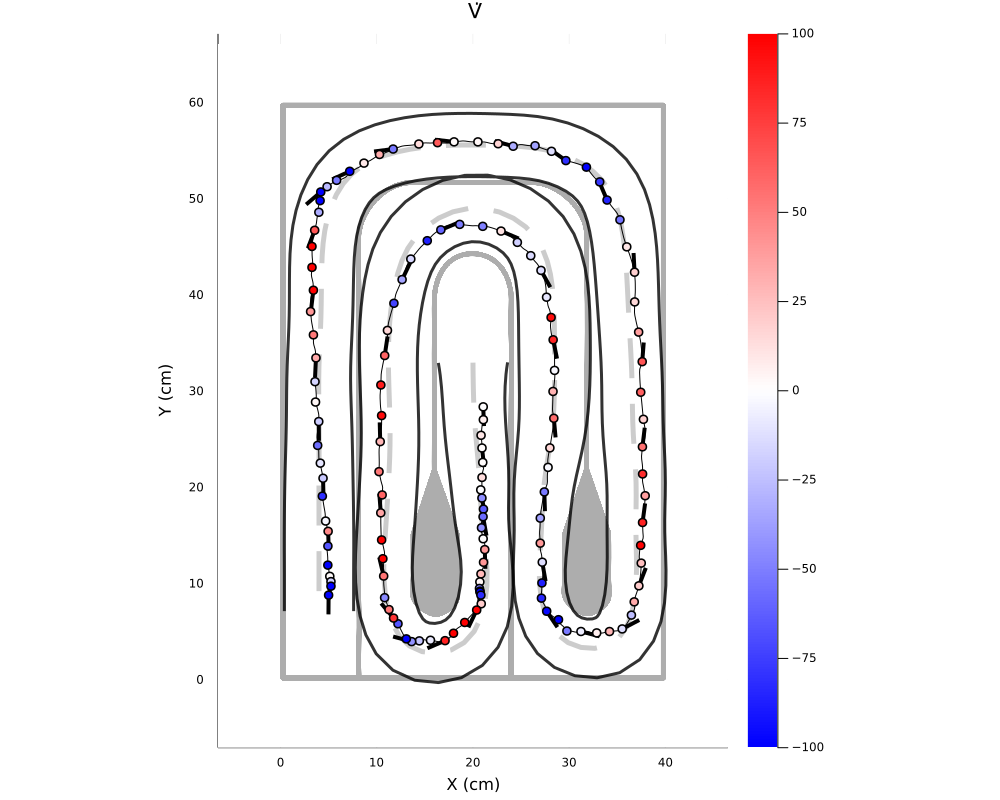

In [110]:
# randomly select a few trials and plot them

color_var = :V̇

trial = rand(ctrials)

plt = draw(:arena)
draw!(FULLTRACK)

plot!(trial.x, trial.y, color="black")
for i in 1:30:length(trial.x)
    x, y, θ = trial.x[i], trial.y[i], trial.θ[i]
    plot!(
        [x, x+2cos(θ)], [y, y+2sin(θ)], lw=4, color="black"
    )
end
scatter!(trial.x[1:10:end], trial.y[1:10:end], marker_z=getfield(trial, color_var)[1:10:end]; 
            c=:bwr, clims=(-100, 100),
            title=color_var, ms=5)

plot(plt, size=(1000, 800), legend=false)

# histogram(trial.n)

### Step 3
Cut the trials into chunks.

In doing so, make sure not to take chunks that are too close of the trial to avoid having problems.

In [111]:
chunks = []
for trial in ctrials
    timesteps = 1:(length(trial.s) - n_samples_chunk -1)
    if length(timesteps) == 0
        continue
    end

    starts = sort!(int.(rand(timesteps, N)))
    stops = int.(starts .+ n_samples_chunk)

 

    for (start, stop) in zip(starts, stops)
        stop >= length(trial.n) && continue

        # if mouse slows down during chunk - ignore
        any(trial.V[start:stop] .<= 25) && continue
        
        push!(chunks, 
            CurvilinearCoordsTrials(
                trial.x[start:stop],
                trial.y[start:stop],
                trial.θ[start:stop],
                trial.s[start:stop],
                trial.n[start:stop],
                trial.ψ[start:stop],
                trial.V[start:stop],
                trial.ω[start:stop],
                trial.V̇[start:stop],
                trial.ω̇[start:stop],
                trial.t[start:stop],
            )
        )
    end
end

@info "Got $(length(chunks)) chunks out of $(length(ctrials)) trials"


@Info (Main):  Got 3067 chunks out of 909 trials 
  ╰──────────────────────────────────────────────── 
                      Tue, 31 May 2022 14:17:56 


### Step 4
for each chunk get the track's curvature ahead at each frame

In [112]:
struct DatasetEntry
    n::Vector{Float64}
    ψ::Vector{Float64}
    s::Vector{Float64}
    V::Vector{Float64}
    ω::Vector{Float64}
    V̇::Vector{Float64}
    ω̇::Vector{Float64}
    k::Union{Nothing, Matrix{Float64}}   # stores the curvature at each waypoint and each frame
end

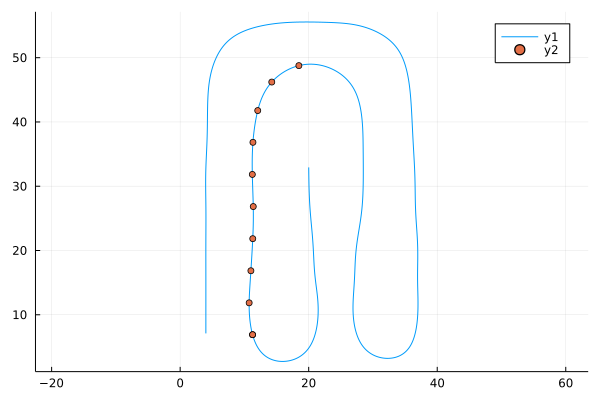

In [113]:
"""
Given an s-value, returns a set of indexes to access the track's variables at equally spaced
points along the track.

"""
function get_track_waypoints(track, sval)
    ds = track.S .- sval
    idxs = findall(
        (diff(mod.(ds, Δs)) .<= 0) .* (ds .>= 0)[2:end] .* (ds .<= S)[2:end],
    )
    return [argmin(ds.^2), idxs...]
end

# visually check that we can select waypoints along the track
if S > 0
    track_idxs = get_track_waypoints(FULLTRACK, 40)
    plot(FULLTRACK.X, FULLTRACK.Y)
    scatter!(FULLTRACK.X[track_idxs], FULLTRACK.Y[track_idxs]; aspect_ratio=:equal)
end

In [114]:
if S > 0
    waypoints = collect(0:Δs:S)
    waypoints_idxs = 1:length(waypoints)
end

entries = []
for chunk in chunks
    # get curvature
    if S > 0
        chunk_curv = zeros(length(waypoints_idxs), length(chunk.x))

        
        for frame in 1:length(chunk.x)
            # get relevant S vector from track
            s = chunk.s[frame]
            idxs = get_track_waypoints(FULLTRACK, s)

            # @assert length(idxs) == length(waypoints_idxs)  "$(length(idxs)) $(length(waypoints_idxs)) $ts $frame $s"
            length(idxs) != length(waypoints_idxs) && continue
            chunk_curv[:, frame] = FULLTRACK.curvature[idxs]
        end
    else
        chunk_curv = nothing
    end

    push!(entries, DatasetEntry(
        chunk.n,
        chunk.ψ,
        chunk.s,
        chunk.V,
        chunk.ω,
        chunk.V̇,
        chunk.ω̇,
        chunk_curv,
    )
    )

end


In [115]:
@info "Got $(length(entries)) entries from $(length(chunks)) chunks"

@Info (Main):  Got 3067 entries from 3067 chunks 
  ╰──────────────────────────────────────────────── 
                      Tue, 31 May 2022 14:48:47 


### Save data
save data to file in a format which can be loaded back in python for RNN training

In [116]:
using JSON: JSON
using DataFrames: DataFrame
import JSONTables: objecttable, jsontable
import OrderedCollections: OrderedDict

savepath = "D:\\Dropbox (UCL)\\Rotation_vte\\Locomotion\\analysis\\RNN\\datasets\\$(S)cm"

for (i, entry) in enumerate(entries)
    if S > 0
        ks = collect(Symbol("k_", i)=>entry.k[i, :] for i in 1:size(entry.k,1 ))
        dict = OrderedDict{Symbol, Union{Vector{Float64}, Matrix{Float64}}}(
            :n=>entry.n,
            :ψ=>entry.ψ,
            :s=>entry.s,
            :V=>entry.V,
            :ω=>entry.ω,
            :V̇=>entry.V̇,
            :ω̇=>entry.ω̇,
            ks...
        )
    else
        dict = OrderedDict{Symbol, Union{Vector{Float64}, Matrix{Float64}}}(
            :n=>entry.n,
            :ψ=>entry.ψ,
            :s=>entry.s,
            :V=>entry.V,
            :ω=>entry.ω,
            :V̇=>entry.V̇,
            :ω̇=>entry.ω̇,
        )
    end
    df = DataFrame(dict)

    open(joinpath(savepath, "$(i).json"), "w") do f
        write(f, objecttable(df))
    end
end